# **ENTRENAMIENTO DEL MODELO DE DETECCIÓN DE PERSONAS - YOLOv11**

# *1. Configuración Inicial y Preparación*

In [2]:
# Instalación de dependencias
!pip install ultralytics
!pip install wandb
!pip install seaborn
!pip install scikit-learn
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [3]:
# Importar librerías necesarias
import os
import yaml
import torch
import numpy as np
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from google.colab import drive
import wandb
from ultralytics import YOLO
import cv2
from IPython.display import clear_output, Image, display
import glob
import shutil
import random
import gc
import json
import time

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Configuración de rutas
BASE_PATH = '/content/drive/MyDrive/Proyecto_IA3'
DATASET_PATH = f'/content/drive/MyDrive/dataset_people'
MODELS_PATH = f'{BASE_PATH}/models'
CHECKPOINTS_PATH = f'{BASE_PATH}/checkpoints'
RESULTS_PATH = f'{BASE_PATH}/results'
LOGS_PATH = f'{BASE_PATH}/logs'


# Crear directorios necesarios
# for path in [MODELS_PATH, CHECKPOINTS_PATH, RESULTS_PATH, LOGS_PATH]:
#     os.makedirs(path, exist_ok=True)

# Configuración de semillas para reproducibilidad
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

In [6]:
# Verificar GPU disponible
!nvidia-smi
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

/bin/bash: line 1: nvidia-smi: command not found
PyTorch version: 2.6.0+cu124
CUDA available: False
CUDA device: None


# **2. Análisis y Visualización del Dataset**

In [ ]:
# Función para validar el dataset
def validate_dataset(dataset_path):
    """Valida la integridad del dataset, verificando imágenes y etiquetas."""
    errors = []
    for split in ['train', 'val', 'test']:
        img_path = os.path.join(dataset_path, 'images', split)
        label_path = os.path.join(dataset_path, 'labels', split)

        if not os.path.exists(img_path) or not os.path.exists(label_path):
            errors.append(f"Directorio faltante: {img_path} o {label_path}")
            continue

        img_files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]
        label_files = [f for f in os.listdir(label_path) if f.endswith('.txt')]

        # Verificar correspondencia entre imágenes y etiquetas
        for img_file in img_files:
            label_file = img_file.replace('.jpg', '.txt')
            if label_file not in label_files:
                errors.append(f"Etiqueta faltante para {img_file} en {split}")

        # Validar contenido de etiquetas
        for label_file in label_files:
            with open(os.path.join(label_path, label_file), 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) != 5:
                        errors.append(f"Formato inválido en {label_file}: {line}")
                        continue
                    class_id, x_center, y_center, width, height = map(float, parts)
                    if class_id != 0 or not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1):
                        errors.append(f"Valores inválidos en {label_file}: {line}")

    return errors

# Ejecutar validación del dataset
validation_errors = validate_dataset(DATASET_PATH)
if validation_errors:
    print("Errores en el dataset:")
    for error in validation_errors:
        print(f"- {error}")
else:
    print("Dataset validado correctamente.")

Dataset validado correctamente.


Dataset Statistics:
--------------------------------------------------
TRAIN:
  Images: 5600
  Labels: 5600
  Total Boxes: 14161
  Avg Boxes/Image: 2.53

VAL:
  Images: 1600
  Labels: 1600
  Total Boxes: 4251
  Avg Boxes/Image: 2.66

TEST:
  Images: 800
  Labels: 800
  Total Boxes: 2113
  Avg Boxes/Image: 2.64



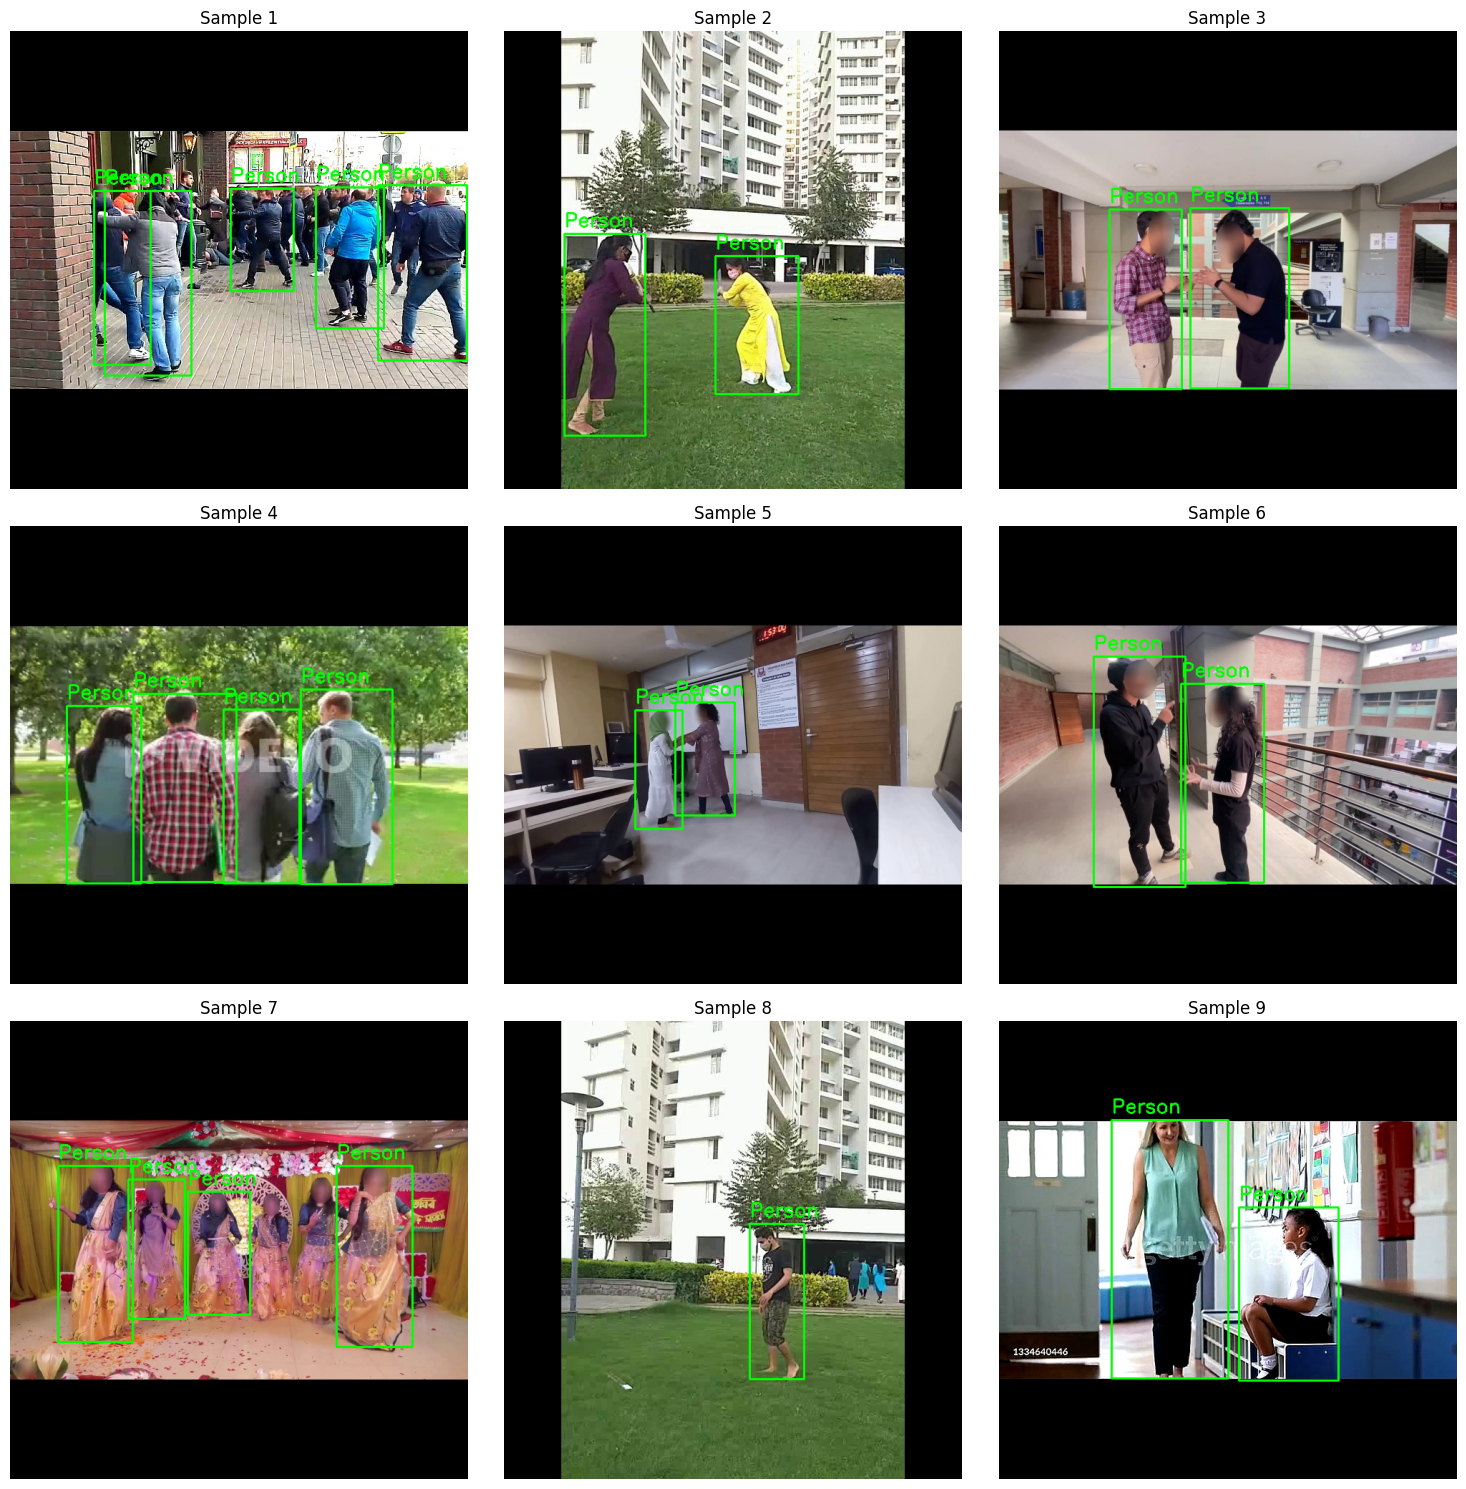

In [ ]:
# Función para analizar el dataset
def analyze_dataset(dataset_path):
    """Analiza la estructura y estadísticas del dataset."""
    stats = {
        'train': {'images': 0, 'labels': 0, 'boxes': 0},
        'val': {'images': 0, 'labels': 0, 'boxes': 0},
        'test': {'images': 0, 'labels': 0, 'boxes': 0}
    }

    for split in ['train', 'val', 'test']:
        # Contar imágenes
        img_path = os.path.join(dataset_path, 'images', split)
        if os.path.exists(img_path):
            stats[split]['images'] = len([f for f in os.listdir(img_path) if f.endswith('.jpg')])

        # Contar labels y boxes
        label_path = os.path.join(dataset_path, 'labels', split)
        if os.path.exists(label_path):
            label_files = [f for f in os.listdir(label_path) if f.endswith('.txt')]
            stats[split]['labels'] = len(label_files)
            total_boxes = 0
            for label_file in label_files:
                with open(os.path.join(label_path, label_file), 'r') as f:
                    total_boxes += len(f.readlines())
            stats[split]['boxes'] = total_boxes

    return stats


# Visualizar estadísticas del dataset
dataset_stats = analyze_dataset(DATASET_PATH)
print("Dataset Statistics:")
print("-" * 50)
for split, stat in dataset_stats.items():
    print(f"{split.upper()}:")
    print(f"  Images: {stat['images']}")
    print(f"  Labels: {stat['labels']}")
    print(f"  Total Boxes: {stat['boxes']}")
    print(f"  Avg Boxes/Image: {stat['boxes']/stat['images'] if stat['images'] > 0 else 0:.2f}")
    print()

# Visualizar muestras del dataset
def visualize_dataset_samples(dataset_path, num_samples=9):
    """Visualiza muestras aleatorias del dataset con sus anotaciones."""
    train_images_path = os.path.join(dataset_path, 'images', 'train')
    train_labels_path = os.path.join(dataset_path, 'labels', 'train')

    image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        img_path = os.path.join(train_images_path, img_file)
        label_path = os.path.join(train_labels_path, img_file.replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    h, w = img.shape[:2]
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, 'Person', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Sample {idx+1}')

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/dataset_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_dataset_samples(DATASET_PATH)

# **3. Transfer Learning (Fase 1)**

In [ ]:
# Cargar el modelo preentrenado
print("Cargando yolo11n.pt...")
model = YOLO('yolo11n.pt')

Cargando yolo11n.pt...


100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [6]:
# Configuración para Transfer Learning
def transfer_learning_phase():
    """Fase 1: Transfer Learning con backbone congelado."""

    # Configurar la clave API de WandB
    try:
        with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo (no recomendado para código compartido).")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB
    wandb.init(
        project="school-violence-detection-yolo11_V2",
        name=f"transfer_learning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "transfer_learning",
            "architecture": "YOLOv11n",
            "frozen_layers": 10,
            "epochs": 30,
            "batch_size": 16,
            "learning_rate": 0.001,
        }
    )

    # Cargar el modelo preentrenado
    print("Cargando yolo11n.pt...")
    model = YOLO('yolo11n.pt')

    # Contador para rastrear épocas
    current_epoch = [0]

    # Callback para imprimir métricas por época
    def on_val_end(validator):
        """Imprime métricas después de cada validación (por época)."""
        current_epoch[0] += 1  # Incrementar contador de épocas

        # Obtener métricas del validator
        metrics = validator.metrics

        # Para YOLOv11, las métricas están en el objeto metrics
        if hasattr(metrics, 'box'):
            print(f"\n=== Época {current_epoch[0]}/30 ===")
            print(f"  Precisión: {metrics.box.mp:.4f}")  # mean precision
            print(f"  Recall: {metrics.box.mr:.4f}")     # mean recall
            print(f"  mAP@50: {metrics.box.map50:.4f}")  # mAP at IoU 0.5
            print(f"  mAP@50-95: {metrics.box.map:.4f}") # mAP at IoU 0.5:0.95
        else:
            print(f"\n=== Época {current_epoch[0]}/30 ===")
            print("  Métricas aún no disponibles")

    # Configuración de hiperparámetros
    transfer_params = {
        'data': f'{DATASET_PATH}/data2.yaml',
        'epochs': 30,
        'batch': 16,
        'imgsz': 640,
        'freeze': 10,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.1,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'save': True,
        'save_period': 5,
        'cache': False,  # Desactivado debido a falta de espacio en disco
        'device': 0,
        'workers': 4,
        'project': f'{MODELS_PATH}/transfer_learning',
        'name': 'exp',
        'exist_ok': True,
        'pretrained': True,
        'verbose': True,
        'seed': 42,
        'deterministic': True,
        'single_cls': True,
        'cos_lr': True,
        'patience': 10,
        'amp': True,
        'plots': True,
    }

    print("Iniciando Transfer Learning con backbone congelado...")
    print(f"Capas congeladas: {transfer_params['freeze']}")

    # Registrar callback
    model.add_callback('on_val_end', on_val_end)

    # Medir tiempo de entrenamiento
    start_time = time.time()

    # Entrenar
    results = model.train(**transfer_params)

    # Calcular tiempo de entrenamiento
    training_time = time.time() - start_time

    # Guardar el modelo
    model.save(f'{CHECKPOINTS_PATH}/transfer_learning_model.pt')

    # Evaluar el modelo
    metrics = model.val()

    # Guardar métricas
    transfer_metrics = {
        'mAP50': float(metrics.box.map50),
        'mAP50-95': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
        'training_time': training_time,
    }

    with open(f'{RESULTS_PATH}/transfer_learning_metrics.json', 'w') as f:
        json.dump(transfer_metrics, f, indent=4)

    # Visualizar curvas de entrenamiento
    plot_training_curves(results, phase='transfer_learning')

    # Limpiar memoria
    gc.collect()
    torch.cuda.empty_cache()

    wandb.finish()

    return model, results, metrics



# Función corregida para visualizar curvas de entrenamiento
def plot_training_curves(results, phase='transfer_learning'):
    """Visualiza las curvas de entrenamiento (pérdida, precisión, recall, mAP)."""

    try:
        # Intentar leer el archivo CSV generado por YOLO
        results_csv = f'{MODELS_PATH}/transfer_learning/exp/results.csv'
        if os.path.exists(results_csv):
            df = pd.read_csv(results_csv)

            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # Graficar pérdidas
            if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
                axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
                axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
                axes[0, 0].set_title('Box Loss')
                axes[0, 0].set_xlabel('Epochs')
                axes[0, 0].set_ylabel('Loss')
                axes[0, 0].legend()
                axes[0, 0].grid(True)

            if 'train/cls_loss' in df.columns and 'val/cls_loss' in df.columns:
                axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
                axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
                axes[0, 1].set_title('Classification Loss')
                axes[0, 1].set_xlabel('Epochs')
                axes[0, 1].set_ylabel('Loss')
                axes[0, 1].legend()
                axes[0, 1].grid(True)

            # Graficar métricas
            if 'metrics/precision(B)' in df.columns and 'metrics/recall(B)' in df.columns:
                axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
                axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
                axes[1, 0].set_title('Precision & Recall')
                axes[1, 0].set_xlabel('Epochs')
                axes[1, 0].set_ylabel('Value')
                axes[1, 0].legend()
                axes[1, 0].grid(True)

            if 'metrics/mAP50(B)' in df.columns and 'metrics/mAP50-95(B)' in df.columns:
                axes[1, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
                axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
                axes[1, 1].set_title('mAP Metrics')
                axes[1, 1].set_xlabel('Epochs')
                axes[1, 1].set_ylabel('mAP')
                axes[1, 1].legend()
                axes[1, 1].grid(True)

            plt.tight_layout()
            plt.savefig(f'{RESULTS_PATH}/{phase}_training_curves.png', dpi=300, bbox_inches='tight')
            plt.show()
            print(f"Gráficas guardadas en: {RESULTS_PATH}/{phase}_training_curves.png")

        else:
            print(f"No se encontró el archivo de resultados en: {results_csv}")

    except Exception as e:
        print(f"Error al generar gráficas: {e}")()




# Función alternativa para extraer métricas del archivo CSV generado por YOLO
def get_training_metrics(results_csv_path=None):
    """Extrae métricas del archivo results.csv generado durante el entrenamiento."""
    if results_csv_path is None:
        results_csv_path = f'{MODELS_PATH}/transfer_learning/exp/results.csv'

    if os.path.exists(results_csv_path):
        df = pd.read_csv(results_csv_path)
        # Mostrar las últimas métricas
        if len(df) > 0:
            last_row = df.iloc[-1]
            print("\nMétricas finales del entrenamiento:")
            print(f"Época: {last_row['epoch']}")
            print(f"mAP@50: {last_row['metrics/mAP50(B)']:.4f}")
            print(f"mAP@50-95: {last_row['metrics/mAP50-95(B)']:.4f}")
            print(f"Precisión: {last_row['metrics/precision(B)']:.4f}")
            print(f"Recall: {last_row['metrics/recall(B)']:.4f}")
        return df
    else:
        print(f"No se encontró el archivo de resultados en {results_csv_path}")
        return None



In [ ]:
# Ejecutar Transfer Learning
print("Iniciando fase de Transfer Learning...")
transfer_model, transfer_results, transfer_metrics = transfer_learning_phase()


# Mostrar métricas finales
if os.path.exists(f'{RESULTS_PATH}/transfer_learning_metrics.json'):
    with open(f'{RESULTS_PATH}/transfer_learning_metrics.json', 'r') as f:
        metrics = json.load(f)
        print("\nMétricas finales de Transfer Learning:")
        print(f"mAP@50: {metrics['mAP50']:.4f}")
        print(f"mAP@50-95: {metrics['mAP50-95']:.4f}")
        print(f"Precisión: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"Tiempo de entrenamiento: {metrics['training_time']:.2f} segundos")

# Verificar si el modelo se guardó correctamente
if os.path.exists(f'{CHECKPOINTS_PATH}/transfer_learning_model.pt'):
    print(f"\nModelo guardado exitosamente en: {CHECKPOINTS_PATH}/transfer_learning_model.pt")
else:
    print("\nAdvertencia: No se encontró el archivo del modelo guardado")

# Extraer métricas adicionales del archivo CSV si está disponible
print("\nIntentando extraer métricas adicionales del archivo CSV...")
csv_metrics = get_training_metrics()
if csv_metrics is not None:
    print("Métricas extraídas exitosamente del archivo CSV")

Iniciando fase de Transfer Learning...


Cargando yolo11n.pt...
Iniciando Transfer Learning con backbone congelado...
Capas congeladas: 10
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/dataset_people/data2.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, o

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7    

YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mo

train: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/train... 5600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5600/5600 [02:25<00:00, 38.39it/s] 


train: New cache created: /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.1±3.1 ms, read: 0.3±0.1 MB/s, size: 103.5 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [01:50<00:00, 14.44it/s] 


val: New cache created: /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val.cache
Plotting labels to /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       1.3G       1.17     0.8925      1.117         72        640: 100%|██████████| 350/350 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


                   all       1600       4251      0.932      0.929      0.976      0.667

=== Época 1/30 ===
  Precisión: 0.9316
  Recall: 0.9286
  mAP@50: 0.9763
  mAP@50-95: 0.6674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.95G      1.145     0.7526      1.131         86        640: 100%|██████████| 350/350 [02:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]

                   all       1600       4251      0.936      0.939      0.976      0.667



=== Época 2/30 ===
  Precisión: 0.9356
  Recall: 0.9393
  mAP@50: 0.9759
  mAP@50-95: 0.6672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.95G      1.147     0.7226      1.136         83        640: 100%|██████████| 350/350 [01:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]

                   all       1600       4251      0.936      0.945      0.978       0.68



=== Época 3/30 ===
  Precisión: 0.9357
  Recall: 0.9447
  mAP@50: 0.9781
  mAP@50-95: 0.6801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.96G      1.116      0.687      1.125         65        640: 100%|██████████| 350/350 [01:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]

                   all       1600       4251      0.939      0.946       0.98      0.696



=== Época 4/30 ===
  Precisión: 0.9385
  Recall: 0.9459
  mAP@50: 0.9803
  mAP@50-95: 0.6964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.96G      1.111      0.676      1.122         82        640: 100%|██████████| 350/350 [01:54<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.23it/s]

                   all       1600       4251       0.95      0.941       0.98        0.7



=== Época 5/30 ===
  Precisión: 0.9496
  Recall: 0.9405
  mAP@50: 0.9804
  mAP@50-95: 0.6998

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.96G      1.096     0.6543      1.116         70        640: 100%|██████████| 350/350 [01:53<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]

                   all       1600       4251      0.947      0.945      0.983      0.707



=== Época 6/30 ===
  Precisión: 0.9470
  Recall: 0.9452
  mAP@50: 0.9833
  mAP@50-95: 0.7073

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.96G      1.087     0.6407      1.109         50        640: 100%|██████████| 350/350 [01:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]

                   all       1600       4251      0.942      0.951      0.983      0.709



=== Época 7/30 ===
  Precisión: 0.9422
  Recall: 0.9511
  mAP@50: 0.9830
  mAP@50-95: 0.7094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.96G       1.07     0.6279      1.106         57        640: 100%|██████████| 350/350 [01:54<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]

                   all       1600       4251      0.942      0.947      0.982      0.711



=== Época 8/30 ===
  Precisión: 0.9423
  Recall: 0.9466
  mAP@50: 0.9816
  mAP@50-95: 0.7114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.96G      1.063     0.6227      1.104         75        640: 100%|██████████| 350/350 [01:54<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]

                   all       1600       4251      0.944      0.948      0.985      0.722



=== Época 9/30 ===
  Precisión: 0.9438
  Recall: 0.9484
  mAP@50: 0.9847
  mAP@50-95: 0.7222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.97G      1.054     0.6062      1.093         86        640: 100%|██████████| 350/350 [01:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

                   all       1600       4251       0.95      0.948      0.985       0.72



=== Época 10/30 ===
  Precisión: 0.9505
  Recall: 0.9480
  mAP@50: 0.9849
  mAP@50-95: 0.7196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.97G      1.051     0.6013      1.095         79        640: 100%|██████████| 350/350 [01:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]

                   all       1600       4251      0.952      0.948      0.984      0.722



=== Época 11/30 ===
  Precisión: 0.9517
  Recall: 0.9475
  mAP@50: 0.9840
  mAP@50-95: 0.7225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.97G      1.037      0.597      1.086         84        640: 100%|██████████| 350/350 [01:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

                   all       1600       4251      0.947      0.951      0.984      0.723



=== Época 12/30 ===
  Precisión: 0.9471
  Recall: 0.9514
  mAP@50: 0.9844
  mAP@50-95: 0.7228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.97G      1.035     0.5899      1.089         78        640: 100%|██████████| 350/350 [01:53<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]

                   all       1600       4251      0.949      0.956      0.986      0.737



=== Época 13/30 ===
  Precisión: 0.9488
  Recall: 0.9558
  mAP@50: 0.9860
  mAP@50-95: 0.7370

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.97G       1.02     0.5769      1.076         66        640: 100%|██████████| 350/350 [01:53<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]

                   all       1600       4251      0.952      0.951      0.985      0.732



=== Época 14/30 ===
  Precisión: 0.9517
  Recall: 0.9508
  mAP@50: 0.9854
  mAP@50-95: 0.7319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.97G       1.01     0.5681      1.072         88        640: 100%|██████████| 350/350 [01:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.63it/s]

                   all       1600       4251      0.951      0.954      0.985       0.73



=== Época 15/30 ===
  Precisión: 0.9505
  Recall: 0.9536
  mAP@50: 0.9851
  mAP@50-95: 0.7298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.97G      1.014     0.5677      1.077         73        640: 100%|██████████| 350/350 [01:52<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]

                   all       1600       4251      0.948      0.954      0.985      0.739



=== Época 16/30 ===
  Precisión: 0.9477
  Recall: 0.9544
  mAP@50: 0.9853
  mAP@50-95: 0.7387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.97G      1.008     0.5566      1.072         72        640: 100%|██████████| 350/350 [01:53<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

                   all       1600       4251      0.952      0.952      0.986      0.734



=== Época 17/30 ===
  Precisión: 0.9524
  Recall: 0.9525
  mAP@50: 0.9865
  mAP@50-95: 0.7336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.97G     0.9953     0.5496      1.064         57        640: 100%|██████████| 350/350 [01:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

                   all       1600       4251      0.952      0.952      0.985      0.743



=== Época 18/30 ===
  Precisión: 0.9519
  Recall: 0.9518
  mAP@50: 0.9854
  mAP@50-95: 0.7429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.97G     0.9938     0.5422      1.057         97        640: 100%|██████████| 350/350 [01:56<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

                   all       1600       4251      0.957      0.952      0.987      0.741



=== Época 19/30 ===
  Precisión: 0.9570
  Recall: 0.9518
  mAP@50: 0.9868
  mAP@50-95: 0.7412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.97G     0.9871     0.5385       1.06         60        640: 100%|██████████| 350/350 [01:54<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

                   all       1600       4251      0.956      0.951      0.986      0.741



=== Época 20/30 ===
  Precisión: 0.9560
  Recall: 0.9509
  mAP@50: 0.9862
  mAP@50-95: 0.7411
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.97G     0.8782     0.4169     0.9788         33        640: 100%|██████████| 350/350 [01:49<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

                   all       1600       4251      0.952      0.955      0.987      0.746



=== Época 21/30 ===
  Precisión: 0.9520
  Recall: 0.9553
  mAP@50: 0.9873
  mAP@50-95: 0.7463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.97G     0.8698      0.411     0.9735         34        640: 100%|██████████| 350/350 [01:46<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

                   all       1600       4251       0.96      0.948      0.987      0.748



=== Época 22/30 ===
  Precisión: 0.9596
  Recall: 0.9485
  mAP@50: 0.9865
  mAP@50-95: 0.7482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.97G     0.8594     0.4023     0.9664         43        640: 100%|██████████| 350/350 [01:49<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.78it/s]

                   all       1600       4251      0.954      0.955      0.988      0.751



=== Época 23/30 ===
  Precisión: 0.9545
  Recall: 0.9551
  mAP@50: 0.9875
  mAP@50-95: 0.7509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.97G     0.8533     0.3936     0.9612         37        640: 100%|██████████| 350/350 [01:45<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]

                   all       1600       4251      0.958      0.951      0.988      0.757



=== Época 24/30 ===
  Precisión: 0.9585
  Recall: 0.9507
  mAP@50: 0.9877
  mAP@50-95: 0.7567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.97G     0.8441     0.3904     0.9579         48        640: 100%|██████████| 350/350 [01:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]

                   all       1600       4251      0.956      0.951      0.987      0.759



=== Época 25/30 ===
  Precisión: 0.9558
  Recall: 0.9506
  mAP@50: 0.9874
  mAP@50-95: 0.7586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.97G     0.8339     0.3781     0.9513         44        640: 100%|██████████| 350/350 [01:45<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

                   all       1600       4251      0.957      0.956      0.988      0.758



=== Época 26/30 ===
  Precisión: 0.9572
  Recall: 0.9562
  mAP@50: 0.9881
  mAP@50-95: 0.7579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.97G     0.8311     0.3742     0.9508         41        640: 100%|██████████| 350/350 [01:46<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]

                   all       1600       4251      0.964      0.947      0.988      0.761



=== Época 27/30 ===
  Precisión: 0.9641
  Recall: 0.9474
  mAP@50: 0.9881
  mAP@50-95: 0.7606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.97G     0.8247     0.3742     0.9484         34        640: 100%|██████████| 350/350 [01:47<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

                   all       1600       4251      0.962       0.95      0.988      0.762



=== Época 28/30 ===
  Precisión: 0.9615
  Recall: 0.9497
  mAP@50: 0.9877
  mAP@50-95: 0.7620

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.97G     0.8212     0.3696     0.9445         38        640: 100%|██████████| 350/350 [01:47<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.52it/s]

                   all       1600       4251      0.957      0.954      0.988      0.763



=== Época 29/30 ===
  Precisión: 0.9575
  Recall: 0.9539
  mAP@50: 0.9882
  mAP@50-95: 0.7632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.97G     0.8178     0.3683     0.9466         38        640: 100%|██████████| 350/350 [01:46<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

                   all       1600       4251       0.96      0.951      0.988      0.762



=== Época 30/30 ===
  Precisión: 0.9601
  Recall: 0.9506
  mAP@50: 0.9882
  mAP@50-95: 0.7624

30 epochs completed in 1.121 hours.
Optimizer stripped from /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


                   all       1600       4251      0.957      0.954      0.988      0.763

=== Época 31/30 ===
  Precisión: 0.9573
  Recall: 0.9537
  mAP@50: 0.9882
  mAP@50-95: 0.7632
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 14.8±8.1 MB/s, size: 98.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


                   all       1600       4251      0.958      0.954      0.988      0.763

=== Época 32/30 ===
  Precisión: 0.9579
  Recall: 0.9538
  mAP@50: 0.9882
  mAP@50-95: 0.7633
Speed: 0.4ms preprocess, 4.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto-IA3/models/transfer_learning/exp
No hay datos de resultados para visualizar



Métricas finales de Transfer Learning:
mAP@50: 0.9882
mAP@50-95: 0.7633
Precisión: 0.9579
Recall: 0.9538
Tiempo de entrenamiento: 4347.02 segundos

Modelo guardado exitosamente en: /content/drive/MyDrive/Proyecto-IA3/checkpoints/transfer_learning_model.pt

Intentando extraer métricas adicionales del archivo CSV...

Métricas finales del entrenamiento:
Época: 30.0
mAP@50: 0.9882
mAP@50-95: 0.7624
Precisión: 0.9601
Recall: 0.9506
Métricas extraídas exitosamente del archivo CSV


# **4. Fine-tuning (Fase 2)**

In [7]:
# Función para Fine-tuning
def fine_tuning_phase(base_model_path):
    """Fase 2: Fine-tuning con modelo completo descongelado."""

    # Configurar la clave API de WandB
    try:
        with open('/content/drive/MyDrive/Proyecto-IA3/wandb_api_key.txt', 'r') as f:
            os.environ["WANDB_API_KEY"] = f.read().strip()
    except FileNotFoundError:
        print("Archivo wandb_api_key.txt no encontrado. Usando clave de respaldo.")
        os.environ["WANDB_API_KEY"] = "30a7a34eb742653f47d9208966cbed1dc6f31e2d"

    # Inicializar WandB para fine-tuning
    wandb.init(
        project="school-violence-detection-yolo11_V2",
        name=f"fine_tuning_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config={
            "phase": "fine_tuning",
            "architecture": "YOLOv11n",
            "frozen_layers": 0,
            "epochs": 50,
            "batch_size": 16,
            "learning_rate": 0.0001,
        }
    )

    # Cargar el modelo de Transfer Learning
    print(f"Cargando modelo desde: {base_model_path}")
    model = YOLO(base_model_path)

    # Contador para rastrear épocas
    current_epoch = [0]

    # Callback para imprimir métricas por época
    def on_val_end(validator):
        """Imprime métricas después de cada validación (por época)."""
        current_epoch[0] += 1

        # Obtener métricas del validator
        metrics = validator.metrics

        # Para YOLOv11, las métricas están en el objeto metrics
        if hasattr(metrics, 'box'):
            print(f"\n=== Época {current_epoch[0]}/50 ===")
            print(f"  Precisión: {metrics.box.mp:.4f}")
            print(f"  Recall: {metrics.box.mr:.4f}")
            print(f"  mAP@50: {metrics.box.map50:.4f}")
            print(f"  mAP@50-95: {metrics.box.map:.4f}")
        else:
            print(f"\n=== Época {current_epoch[0]}/50 ===")
            print("  Métricas aún no disponibles")

    # Configuración de hiperparámetros para fine-tuning
    finetune_params = {
        'data': f'{DATASET_PATH}/data2.yaml',
        'epochs': 50,
        'batch': 16,
        'imgsz': 640,
        'freeze': None,  # No congelar capas en fine-tuning
        'optimizer': 'AdamW',
        'lr0': 0.0001,  # Learning rate más bajo para fine-tuning
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'save': True,
        'save_period': 5,
        'cache': False,
        'device': 0,
        'workers': 4,
        'project': f'{MODELS_PATH}/fine_tuning',
        'name': 'exp',
        'exist_ok': True,
        'verbose': True,
        'seed': 42,
        'deterministic': True,
        'single_cls': True,
        'cos_lr': True,
        'patience': 15,  # Mayor paciencia para fine-tuning
        'amp': True,
        'plots': True,
        'resume': False,
    }

    print("Iniciando Fine-tuning con modelo completo...")
    print("Todas las capas están descongeladas")

    # Registrar callback
    model.add_callback('on_val_end', on_val_end)

    # Medir tiempo de entrenamiento
    start_time = time.time()

    # Entrenar
    results = model.train(**finetune_params)

    # Calcular tiempo de entrenamiento
    training_time = time.time() - start_time

    # Guardar el modelo final
    model.save(f'{MODELS_PATH}/yolo11_people_final.pt')

    # Evaluar el modelo
    metrics = model.val()

    # Guardar métricas
    finetune_metrics = {
        'mAP50': float(metrics.box.map50),
        'mAP50-95': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
        'training_time': training_time,
    }

    with open(f'{RESULTS_PATH}/fine_tuning_metrics.json', 'w') as f:
        json.dump(finetune_metrics, f, indent=4)

    # Visualizar curvas de entrenamiento
    plot_training_curves(results, phase='fine_tuning')

    # Limpiar memoria
    gc.collect()
    torch.cuda.empty_cache()

    wandb.finish()

    return model, results, metrics



In [8]:
CHECKPOINTS = '/content/drive/MyDrive/Proyecto-IA3/checkpoints/transfer_learning_model.pt'

# Ejecutar Fine-tuning
print("\nIniciando fase de Fine-tuning...")
final_model, finetune_results, finetune_metrics = fine_tuning_phase(CHECKPOINTS)

# Mostrar métricas finales
if os.path.exists(f'{RESULTS_PATH}/fine_tuning_metrics.json'):
    with open(f'{RESULTS_PATH}/fine_tuning_metrics.json', 'r') as f:
        metrics = json.load(f)
        print("\nMétricas finales de Fine-tuning:")
        print(f"mAP@50: {metrics['mAP50']:.4f}")
        print(f"mAP@50-95: {metrics['mAP50-95']:.4f}")
        print(f"Precisión: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"Tiempo de entrenamiento: {metrics['training_time']:.2f} segundos")

# Verificar si el modelo final se guardó correctamente
if os.path.exists(f'{MODELS_PATH}/yolo11_people_final.pt'):
    print(f"\nModelo final guardado exitosamente en: {MODELS_PATH}/yolo11_people_final.pt")
else:
    print("\nAdvertencia: No se encontró el archivo del modelo final")

# Comparar métricas de Transfer Learning vs Fine-tuning
print("\nComparación de resultados:")
print("=" * 50)

if os.path.exists(f'{RESULTS_PATH}/transfer_learning_metrics.json') and os.path.exists(f'{RESULTS_PATH}/fine_tuning_metrics.json'):
    with open(f'{RESULTS_PATH}/transfer_learning_metrics.json', 'r') as f:
        transfer_metrics = json.load(f)
    with open(f'{RESULTS_PATH}/fine_tuning_metrics.json', 'r') as f:
        finetune_metrics = json.load(f)

    print("Métrica          Transfer Learning  Fine-tuning   Mejora")
    print("-" * 55)

    for metric in ['mAP50', 'mAP50-95', 'precision', 'recall']:
        transfer_value = transfer_metrics[metric]
        finetune_value = finetune_metrics[metric]
        improvement = ((finetune_value - transfer_value) / transfer_value) * 100

        print(f"{metric:<15} {transfer_value:.4f}           {finetune_value:.4f}       {improvement:+.2f}%")

    print("=" * 50)


Iniciando fase de Fine-tuning...


wandb: Currently logged in as: gonzalesfranzreinaldo (gonzalesfranzreinaldo-usfx) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Cargando modelo desde: /content/drive/MyDrive/Proyecto-IA3/checkpoints/transfer_learning_model.pt
Iniciando Fine-tuning con modelo completo...
Todas las capas están descongeladas
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/dataset_people/data2.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/M

100%|██████████| 755k/755k [00:00<00:00, 79.7MB/s]

Overriding class names with single class.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultraly

 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 499/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 208MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.2 ms, read: 0.1±0.1 MB/s, size: 114.5 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/train.cache... 5600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5600/5600 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.1±0.0 MB/s, size: 103.5 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.17G      1.063     0.6128      1.096         72        640: 100%|██████████| 350/350 [04:52<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [10:36<00:00, 12.74s/it]

                   all       1600       4251      0.951      0.928       0.98      0.719



=== Época 1/50 ===
  Precisión: 0.9506
  Recall: 0.9276
  mAP@50: 0.9797
  mAP@50-95: 0.7185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.7G     0.9966     0.5569      1.063         86        640: 100%|██████████| 350/350 [02:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:20<00:00,  2.39it/s]

                   all       1600       4251      0.947      0.947      0.984      0.732



=== Época 2/50 ===
  Precisión: 0.9469
  Recall: 0.9466
  mAP@50: 0.9840
  mAP@50-95: 0.7319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.7G     0.9763      0.534      1.056         83        640: 100%|██████████| 350/350 [02:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]

                   all       1600       4251      0.955      0.944      0.985      0.738



=== Época 3/50 ===
  Precisión: 0.9547
  Recall: 0.9435
  mAP@50: 0.9851
  mAP@50-95: 0.7377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.72G     0.9595     0.5164      1.046         65        640: 100%|██████████| 350/350 [02:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.50it/s]

                   all       1600       4251      0.954      0.957      0.987      0.733



=== Época 4/50 ===
  Precisión: 0.9540
  Recall: 0.9567
  mAP@50: 0.9874
  mAP@50-95: 0.7327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.73G      0.956     0.5192      1.044         82        640: 100%|██████████| 350/350 [02:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]

                   all       1600       4251      0.957      0.954      0.988      0.748



=== Época 5/50 ===
  Precisión: 0.9573
  Recall: 0.9545
  mAP@50: 0.9876
  mAP@50-95: 0.7481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.73G     0.9503     0.5136      1.041         70        640: 100%|██████████| 350/350 [02:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]

                   all       1600       4251      0.953      0.956      0.987       0.74



=== Época 6/50 ===
  Precisión: 0.9532
  Recall: 0.9555
  mAP@50: 0.9874
  mAP@50-95: 0.7403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.73G     0.9567     0.5087      1.045         50        640: 100%|██████████| 350/350 [02:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]

                   all       1600       4251      0.959      0.951      0.988       0.75



=== Época 7/50 ===
  Precisión: 0.9594
  Recall: 0.9512
  mAP@50: 0.9879
  mAP@50-95: 0.7505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.73G     0.9346     0.5036      1.036         57        640: 100%|██████████| 350/350 [02:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]

                   all       1600       4251      0.955      0.954      0.987       0.74



=== Época 8/50 ===
  Precisión: 0.9545
  Recall: 0.9537
  mAP@50: 0.9869
  mAP@50-95: 0.7397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.73G     0.9359     0.5021      1.034         75        640: 100%|██████████| 350/350 [02:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

                   all       1600       4251      0.954      0.953      0.987       0.75



=== Época 9/50 ===
  Precisión: 0.9543
  Recall: 0.9526
  mAP@50: 0.9866
  mAP@50-95: 0.7498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.73G     0.9314     0.4953      1.033         86        640: 100%|██████████| 350/350 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]

                   all       1600       4251       0.96      0.948      0.988      0.755



=== Época 10/50 ===
  Precisión: 0.9605
  Recall: 0.9480
  mAP@50: 0.9877
  mAP@50-95: 0.7551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.73G     0.9266     0.5007      1.031         79        640: 100%|██████████| 350/350 [02:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]

                   all       1600       4251       0.96      0.948      0.987      0.748



=== Época 11/50 ===
  Precisión: 0.9595
  Recall: 0.9477
  mAP@50: 0.9871
  mAP@50-95: 0.7476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.75G     0.9209     0.4949      1.028         84        640: 100%|██████████| 350/350 [02:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

                   all       1600       4251      0.955      0.954      0.986       0.74



=== Época 12/50 ===
  Precisión: 0.9553
  Recall: 0.9537
  mAP@50: 0.9859
  mAP@50-95: 0.7396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.75G     0.9243     0.4952      1.032         78        640: 100%|██████████| 350/350 [01:59<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]

                   all       1600       4251      0.959      0.953      0.987      0.756



=== Época 13/50 ===
  Precisión: 0.9593
  Recall: 0.9526
  mAP@50: 0.9871
  mAP@50-95: 0.7563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.75G     0.9151     0.4884      1.027         66        640: 100%|██████████| 350/350 [01:59<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

                   all       1600       4251      0.958       0.95      0.987      0.744



=== Época 14/50 ===
  Precisión: 0.9582
  Recall: 0.9504
  mAP@50: 0.9873
  mAP@50-95: 0.7440

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.75G     0.9096     0.4848      1.021         88        640: 100%|██████████| 350/350 [01:59<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

                   all       1600       4251      0.958      0.949      0.986      0.743



=== Época 15/50 ===
  Precisión: 0.9577
  Recall: 0.9491
  mAP@50: 0.9861
  mAP@50-95: 0.7434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.75G     0.9161     0.4901      1.029         73        640: 100%|██████████| 350/350 [01:59<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]

                   all       1600       4251      0.956      0.956      0.988      0.758



=== Época 16/50 ===
  Precisión: 0.9560
  Recall: 0.9564
  mAP@50: 0.9876
  mAP@50-95: 0.7576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.75G     0.9118     0.4823      1.025         72        640: 100%|██████████| 350/350 [02:00<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]

                   all       1600       4251      0.962      0.952      0.988      0.755



=== Época 17/50 ===
  Precisión: 0.9620
  Recall: 0.9515
  mAP@50: 0.9876
  mAP@50-95: 0.7550

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.75G     0.9036     0.4823      1.023         57        640: 100%|██████████| 350/350 [01:59<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

                   all       1600       4251      0.965      0.946      0.988      0.758



=== Época 18/50 ===
  Precisión: 0.9647
  Recall: 0.9464
  mAP@50: 0.9883
  mAP@50-95: 0.7581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.75G     0.9034     0.4803      1.019         97        640: 100%|██████████| 350/350 [02:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]

                   all       1600       4251       0.96      0.948      0.987      0.757



=== Época 19/50 ===
  Precisión: 0.9603
  Recall: 0.9485
  mAP@50: 0.9871
  mAP@50-95: 0.7568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.75G     0.9068     0.4788      1.024         60        640: 100%|██████████| 350/350 [01:58<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

                   all       1600       4251      0.953      0.954      0.987      0.756



=== Época 20/50 ===
  Precisión: 0.9532
  Recall: 0.9537
  mAP@50: 0.9868
  mAP@50-95: 0.7563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.75G     0.9124     0.4813      1.023         68        640: 100%|██████████| 350/350 [01:57<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]

                   all       1600       4251      0.956      0.955      0.987      0.757



=== Época 21/50 ===
  Precisión: 0.9559
  Recall: 0.9546
  mAP@50: 0.9874
  mAP@50-95: 0.7568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.75G     0.9081     0.4779      1.023        100        640: 100%|██████████| 350/350 [01:58<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]

                   all       1600       4251      0.956      0.954      0.988      0.749



=== Época 22/50 ===
  Precisión: 0.9557
  Recall: 0.9544
  mAP@50: 0.9880
  mAP@50-95: 0.7489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.75G     0.9079     0.4797      1.023         82        640: 100%|██████████| 350/350 [01:56<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

                   all       1600       4251      0.957      0.957      0.988      0.751



=== Época 23/50 ===
  Precisión: 0.9565
  Recall: 0.9574
  mAP@50: 0.9878
  mAP@50-95: 0.7506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.75G     0.9036     0.4752      1.022         94        640: 100%|██████████| 350/350 [02:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

                   all       1600       4251      0.952      0.964      0.988      0.753



=== Época 24/50 ===
  Precisión: 0.9519
  Recall: 0.9638
  mAP@50: 0.9883
  mAP@50-95: 0.7525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.75G     0.9018     0.4724      1.019         74        640: 100%|██████████| 350/350 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]

                   all       1600       4251      0.958      0.954      0.987      0.758



=== Época 25/50 ===
  Precisión: 0.9582
  Recall: 0.9542
  mAP@50: 0.9874
  mAP@50-95: 0.7582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.75G     0.8935     0.4716      1.016         67        640: 100%|██████████| 350/350 [01:57<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

                   all       1600       4251      0.959      0.951      0.988      0.757



=== Época 26/50 ===
  Precisión: 0.9588
  Recall: 0.9506
  mAP@50: 0.9877
  mAP@50-95: 0.7573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.75G     0.9041     0.4736      1.022         82        640: 100%|██████████| 350/350 [02:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

                   all       1600       4251      0.963      0.953      0.988      0.759



=== Época 27/50 ===
  Precisión: 0.9629
  Recall: 0.9530
  mAP@50: 0.9880
  mAP@50-95: 0.7593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.75G     0.8953     0.4683       1.02         62        640: 100%|██████████| 350/350 [02:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

                   all       1600       4251      0.962      0.949      0.988      0.754



=== Época 28/50 ===
  Precisión: 0.9616
  Recall: 0.9490
  mAP@50: 0.9882
  mAP@50-95: 0.7544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.75G     0.8885     0.4631      1.017         54        640: 100%|██████████| 350/350 [02:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

                   all       1600       4251      0.955      0.956      0.987      0.758



=== Época 29/50 ===
  Precisión: 0.9552
  Recall: 0.9560
  mAP@50: 0.9870
  mAP@50-95: 0.7584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.75G     0.8916     0.4649      1.015         97        640: 100%|██████████| 350/350 [01:59<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]

                   all       1600       4251      0.954      0.956      0.987      0.757



=== Época 30/50 ===
  Precisión: 0.9541
  Recall: 0.9565
  mAP@50: 0.9875
  mAP@50-95: 0.7570

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.75G      0.883     0.4668      1.014         60        640: 100%|██████████| 350/350 [02:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]

                   all       1600       4251      0.956      0.955      0.987      0.756



=== Época 31/50 ===
  Precisión: 0.9562
  Recall: 0.9550
  mAP@50: 0.9874
  mAP@50-95: 0.7564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.75G     0.8828     0.4675      1.012         62        640: 100%|██████████| 350/350 [02:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

                   all       1600       4251      0.953      0.956      0.988      0.761



=== Época 32/50 ===
  Precisión: 0.9532
  Recall: 0.9558
  mAP@50: 0.9879
  mAP@50-95: 0.7608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.75G       0.88     0.4607      1.009         66        640: 100%|██████████| 350/350 [01:57<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]

                   all       1600       4251      0.953      0.959      0.988      0.761



=== Época 33/50 ===
  Precisión: 0.9534
  Recall: 0.9585
  mAP@50: 0.9875
  mAP@50-95: 0.7606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.75G     0.8848     0.4607      1.013         61        640: 100%|██████████| 350/350 [02:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]

                   all       1600       4251       0.96      0.955      0.988      0.758



=== Época 34/50 ===
  Precisión: 0.9595
  Recall: 0.9551
  mAP@50: 0.9878
  mAP@50-95: 0.7582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.75G     0.8815     0.4639       1.01         65        640: 100%|██████████| 350/350 [01:58<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]

                   all       1600       4251      0.961       0.95      0.988      0.759



=== Época 35/50 ===
  Precisión: 0.9614
  Recall: 0.9496
  mAP@50: 0.9880
  mAP@50-95: 0.7585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.75G      0.878     0.4585      1.009         62        640: 100%|██████████| 350/350 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]

                   all       1600       4251      0.964      0.947      0.988      0.759



=== Época 36/50 ===
  Precisión: 0.9645
  Recall: 0.9473
  mAP@50: 0.9882
  mAP@50-95: 0.7591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.75G     0.8674     0.4535      1.006         68        640: 100%|██████████| 350/350 [01:59<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]

                   all       1600       4251      0.953      0.959      0.987      0.762



=== Época 37/50 ===
  Precisión: 0.9525
  Recall: 0.9586
  mAP@50: 0.9874
  mAP@50-95: 0.7622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.75G     0.8682     0.4511      1.004         55        640: 100%|██████████| 350/350 [02:03<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.78it/s]

                   all       1600       4251      0.948      0.964      0.988      0.756



=== Época 38/50 ===
  Precisión: 0.9482
  Recall: 0.9645
  mAP@50: 0.9878
  mAP@50-95: 0.7563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.75G     0.8786      0.458      1.009         77        640: 100%|██████████| 350/350 [02:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]

                   all       1600       4251      0.956      0.957      0.987      0.763



=== Época 39/50 ===
  Precisión: 0.9561
  Recall: 0.9574
  mAP@50: 0.9874
  mAP@50-95: 0.7632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.75G     0.8779     0.4548      1.011         75        640: 100%|██████████| 350/350 [02:10<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]

                   all       1600       4251      0.953       0.96      0.987      0.761



=== Época 40/50 ===
  Precisión: 0.9531
  Recall: 0.9598
  mAP@50: 0.9875
  mAP@50-95: 0.7610
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.75G     0.7679     0.3451     0.9262         46        640: 100%|██████████| 350/350 [02:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]

                   all       1600       4251      0.957       0.96      0.988      0.753



=== Época 41/50 ===
  Precisión: 0.9571
  Recall: 0.9602
  mAP@50: 0.9880
  mAP@50-95: 0.7531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.75G     0.7632     0.3394     0.9233         39        640: 100%|██████████| 350/350 [01:53<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]

                   all       1600       4251      0.957       0.96      0.988      0.754



=== Época 42/50 ===
  Precisión: 0.9569
  Recall: 0.9599
  mAP@50: 0.9882
  mAP@50-95: 0.7538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.75G     0.7651     0.3376     0.9238         47        640: 100%|██████████| 350/350 [01:51<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]

                   all       1600       4251      0.954       0.96      0.988      0.758



=== Época 43/50 ===
  Precisión: 0.9542
  Recall: 0.9605
  mAP@50: 0.9880
  mAP@50-95: 0.7576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.75G     0.7594      0.336     0.9237         36        640: 100%|██████████| 350/350 [01:54<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

                   all       1600       4251      0.954      0.962      0.988      0.757



=== Época 44/50 ===
  Precisión: 0.9543
  Recall: 0.9620
  mAP@50: 0.9883
  mAP@50-95: 0.7573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.75G      0.758     0.3367     0.9211         37        640: 100%|██████████| 350/350 [01:54<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]

                   all       1600       4251      0.955      0.961      0.988      0.756



=== Época 45/50 ===
  Precisión: 0.9551
  Recall: 0.9610
  mAP@50: 0.9882
  mAP@50-95: 0.7556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.75G     0.7573     0.3345     0.9186         42        640: 100%|██████████| 350/350 [01:53<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]

                   all       1600       4251      0.957      0.961      0.988      0.759



=== Época 46/50 ===
  Precisión: 0.9572
  Recall: 0.9607
  mAP@50: 0.9882
  mAP@50-95: 0.7587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.75G     0.7526     0.3341     0.9197         47        640: 100%|██████████| 350/350 [01:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

                   all       1600       4251      0.955      0.961      0.988      0.758



=== Época 47/50 ===
  Precisión: 0.9549
  Recall: 0.9612
  mAP@50: 0.9883
  mAP@50-95: 0.7580

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.75G     0.7534     0.3325     0.9186         37        640: 100%|██████████| 350/350 [01:54<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

                   all       1600       4251      0.953      0.962      0.988      0.759



=== Época 48/50 ===
  Precisión: 0.9529
  Recall: 0.9619
  mAP@50: 0.9882
  mAP@50-95: 0.7586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.75G     0.7556     0.3326     0.9204         36        640: 100%|██████████| 350/350 [01:59<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]

                   all       1600       4251      0.954      0.961      0.988      0.759



=== Época 49/50 ===
  Precisión: 0.9540
  Recall: 0.9614
  mAP@50: 0.9883
  mAP@50-95: 0.7588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.75G     0.7528     0.3314     0.9177         40        640: 100%|██████████| 350/350 [01:53<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

                   all       1600       4251      0.955      0.961      0.988      0.759



=== Época 50/50 ===
  Precisión: 0.9549
  Recall: 0.9612
  mAP@50: 0.9883
  mAP@50-95: 0.7585

50 epochs completed in 2.154 hours.
Optimizer stripped from /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


                   all       1600       4251      0.956      0.957      0.987      0.763

=== Época 51/50 ===
  Precisión: 0.9558
  Recall: 0.9574
  mAP@50: 0.9874
  mAP@50-95: 0.7629
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 0.1±0.1 MB/s, size: 98.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


                   all       1600       4251      0.956      0.957      0.987      0.763

=== Época 52/50 ===
  Precisión: 0.9562
  Recall: 0.9574
  mAP@50: 0.9874
  mAP@50-95: 0.7632
Speed: 0.5ms preprocess, 4.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp
No se encontró el archivo de resultados en: /content/drive/MyDrive/Proyecto_IA3/models/transfer_learning/exp/results.csv



Métricas finales de Fine-tuning:
mAP@50: 0.9874
mAP@50-95: 0.7632
Precisión: 0.9562
Recall: 0.9574
Tiempo de entrenamiento: 7891.64 segundos

Modelo final guardado exitosamente en: /content/drive/MyDrive/Proyecto_IA3/models/yolo11_people_final.pt

Comparación de resultados:


# **5. Evaluación Completa y Métricas**

In [ ]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Definir rutas
DATASET_PATH = '/content/drive/MyDrive/dataset_people'
MODELS_PATH = '/content/drive/MyDrive/Proyecto_IA3/models'
RESULTS_PATH = '/content/drive/MyDrive/Proyecto_IA3/results'

# Ruta del modelo de Fine-Tuning
MODEL_PATH = f'{MODELS_PATH}/yolo11_people_final.pt'

# Verificar que el modelo existe
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo en {MODEL_PATH}. Verifica la ruta o si el modelo se guardó correctamente.")

# Cargar el modelo
print(f"Cargando modelo desde: {MODEL_PATH}")
final_model = YOLO(MODEL_PATH)

# Verificar que el modelo se cargó correctamente
try:
    final_model.info()
    print("Modelo cargado exitosamente.")
except Exception as e:
    raise RuntimeError(f"Error al cargar el modelo: {e}")

In [16]:
# Evaluación exhaustiva con métricas adicionales
def comprehensive_evaluation(model, dataset_path):
    """Realiza una evaluación completa con métricas binarias y curvas."""

    # Evaluar en validación y test
    val_metrics = model.val(data=f'{dataset_path}/data2.yaml', split='val')
    test_metrics = model.val(data=f'{dataset_path}/data2.yaml', split='test')

    def compute_binary_metrics(split='test'):
        """Calcula matriz de confusión, sensibilidad, especificidad, TPR, FPR."""
        test_images_path = os.path.join(dataset_path, 'images', split)
        test_labels_path = os.path.join(dataset_path, 'labels', split)

        y_true = []
        y_pred = []
        y_scores = []

        for img_file in os.listdir(test_images_path):
            if not img_file.endswith('.jpg'):
                continue
            img_path = os.path.join(test_images_path, img_file)
            label_path = os.path.join(test_labels_path, img_file.replace('.jpg', '.txt'))

            # Etiqueta real: 1 si hay al menos un bounding box, 0 si no
            true_label = 1 if os.path.exists(label_path) and os.path.getsize(label_path) > 0 else 0
            y_true.append(true_label)

            # Predicción
            results = model(img_path, verbose=False)
            pred_label = 1 if len(results[0].boxes) > 0 else 0
            y_pred.append(pred_label)

            # Score de confianza
            if len(results[0].boxes) > 0:
                scores = results[0].boxes.conf.cpu().numpy()
                y_scores.append(float(max(scores)))
            else:
                y_scores.append(0.0)

        # Calcular métricas
        # Forzar matriz 2x2 con labels=[0, 1]
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        tpr = sensitivity
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        # Curvas ROC y Precision-Recall
        fpr_curve, tpr_curve, _ = roc_curve(y_true, y_scores, pos_label=1)
        roc_auc = auc(fpr_curve, tpr_curve)
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores, pos_label=1)
        pr_auc = auc(recall_curve, precision_curve)

        return {
            'confusion_matrix': cm.tolist(),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'tpr': float(tpr),
            'fpr': float(fpr),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'fpr_curve': fpr_curve.tolist(),
            'tpr_curve': tpr_curve.tolist(),
            'precision_curve': precision_curve.tolist(),
            'recall_curve': recall_curve.tolist(),
        }

    test_binary_metrics = compute_binary_metrics(split='test')

    # Consolidar resultados
    eval_results = {
        'validation': {
            'mAP50': float(val_metrics.box.map50),
            'mAP50-95': float(val_metrics.box.map),
            'precision': float(val_metrics.box.mp),
            'recall': float(val_metrics.box.mr),
            'f1_score': 2 * float(val_metrics.box.mp) * float(val_metrics.box.mr) /
                        (float(val_metrics.box.mp) + float(val_metrics.box.mr) + 1e-6),
        },
        'test': {
            'mAP50': float(test_metrics.box.map50),
            'mAP50-95': float(test_metrics.box.map),
            'precision': float(test_metrics.box.mp),
            'recall': float(test_metrics.box.mr),
            'f1_score': 2 * float(test_metrics.box.mp) * float(test_metrics.box.mr) /
                        (float(test_metrics.box.mp) + float(test_metrics.box.mr) + 1e-6),
            'binary_metrics': test_binary_metrics,
        }
    }

    # Guardar resultados
    with open(f'{RESULTS_PATH}/final_evaluation_metrics.json', 'w') as f:
        json.dump(eval_results, f, indent=4)

    # Visualizar métricas
    plot_evaluation_metrics(eval_results)

    return eval_results

def plot_evaluation_metrics(eval_results):
    """Visualiza métricas de evaluación, incluyendo matriz de confusión y curvas."""
    # Gráfico de métricas estándar
    metrics = ['mAP50', 'mAP50-95', 'precision', 'recall', 'f1_score']
    val_values = [eval_results['validation'][m] for m in metrics]
    test_values = [eval_results['test'][m] for m in metrics]

    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(metrics))
    width = 0.35
    bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
    ax.set_ylabel('Score')
    ax.set_title('Model Evaluation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Añadir valores sobre las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualizar matriz de confusión
    cm = np.array(eval_results['test']['binary_metrics']['confusion_matrix'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Person', 'Person'],
                yticklabels=['No Person', 'Person'])
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{RESULTS_PATH}/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualizar curvas ROC y Precision-Recall
    fpr = np.array(eval_results['test']['binary_metrics']['fpr_curve'])
    tpr = np.array(eval_results['test']['binary_metrics']['tpr_curve'])
    roc_auc = eval_results['test']['binary_metrics']['roc_auc']

    precision = np.array(eval_results['test']['binary_metrics']['precision_curve'])
    recall = np.array(eval_results['test']['binary_metrics']['recall_curve'])
    pr_auc = eval_results['test']['binary_metrics']['pr_auc']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)

    # Precision-Recall Curve
    ax2.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{RESULTS_PATH}/roc_pr_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Ejecutar todas las evaluaciones
print("Ejecutando evaluación completa...")
evaluation_results = comprehensive_evaluation(final_model, DATASET_PATH)

Ejecutando evaluación completa...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 29.3±13.9 MB/s, size: 97.3 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


                   all       1600       4251      0.956      0.957      0.987      0.763

=== Época 61/50 ===
  Precisión: 0.9562
  Recall: 0.9574
  mAP@50: 0.9874
  mAP@50-95: 0.7632
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 48.9±15.0 MB/s, size: 110.9 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1EKy5MKJmoLNQxoFyuOzjyUbOAB4YbrrM/dataset_people/labels/test.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


                   all        800       2113      0.967      0.952       0.99      0.774

=== Época 62/50 ===
  Precisión: 0.9671
  Recall: 0.9522
  mAP@50: 0.9898
  mAP@50-95: 0.7735
Speed: 1.0ms preprocess, 4.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/Proyecto_IA3/models/fine_tuning/exp


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

#  Análisis de falsos positivos/negativos

In [11]:
# Análisis de falsos positivos/negativos
def analyze_false_predictions(model, dataset_path, split='test', num_samples=10):
    """Analiza y visualiza falsos positivos y negativos."""
    test_images_path = os.path.join(dataset_path, 'images', split)
    test_labels_path = os.path.join(dataset_path, 'labels', split)

    image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
    false_positives = []
    false_negatives = []

    for img_file in image_files:
        img_path = os.path.join(test_images_path, img_file)
        label_path = os.path.join(test_labels_path, img_file.replace('.jpg', '.txt'))

        true_label = 1 if os.path.exists(label_path) and os.path.getsize(label_path) > 0 else 0
        results = model(img_path, verbose=False)
        pred_label = 1 if len(results[0].boxes) > 0 else 0

        if true_label == 0 and pred_label == 1:
            false_positives.append(img_file)
        elif true_label == 1 and pred_label == 0:
            false_negatives.append(img_file)

    # Visualizar muestras
    def visualize_samples(title, samples, max_samples=5):
        if not samples:
            print(f"No {title} encontrados.")
            return

        samples = random.sample(samples, min(max_samples, len(samples)))
        fig, axes = plt.subplots(1, len(samples), figsize=(5 * len(samples), 5))
        if len(samples) == 1:
            axes = [axes]

        for idx, img_file in enumerate(samples):
            img_path = os.path.join(test_images_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            results = model(img_path, verbose=False)
            for box in results[0].boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, f'{conf:.2f}', (x1, y1-10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(img_file[:20] + '...', fontsize=10)

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{RESULTS_PATH}/{title.lower().replace(" ", "_")}.png',
                   dpi=300, bbox_inches='tight')
        plt.show()

    visualize_samples("False Positives", false_positives)
    visualize_samples("False Negatives", false_negatives)

    return {
        'false_positives': len(false_positives),
        'false_negatives': len(false_negatives),
        'total_images': len(image_files),
        'fp_rate': len(false_positives) / len(image_files) if image_files else 0,
        'fn_rate': len(false_negatives) / len(image_files) if image_files else 0,
    }

print("\nAnalizando falsos positivos y negativos...")
false_predictions = analyze_false_predictions(final_model, DATASET_PATH)
print("False Predictions Analysis:")
print(f"False Positives: {false_predictions['false_positives']} ({false_predictions['fp_rate']:.3f})")
print(f"False Negatives: {false_predictions['false_negatives']} ({false_predictions['fn_rate']:.3f})")

No False Positives encontrados.
No False Negatives encontrados.
False Predictions Analysis:
False Positives: 0 (0.000)
False Negatives: 0 (0.000)


# **6. Análisis de Rendimiento e Inferencia**

In [ ]:
# Análisis de rendimiento en inferencia
def analyze_inference_performance(model, test_images_path, num_samples=100):
    """Analiza el rendimiento del modelo en inferencia."""
    image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    inference_times = []
    preprocessing_times = []
    postprocessing_times = []

    for img_file in sample_files:
        img_path = os.path.join(test_images_path, img_file)

        # Medir tiempo total
        start_time = time.time()
        results = model(img_path, verbose=False)
        end_time = time.time()

        total_time = (end_time - start_time) * 1000  # convertir a ms
        inference_times.append(total_time)

        # Obtener tiempos específicos si están disponibles
        if hasattr(results[0], 'speed'):
            preprocessing_times.append(results[0].speed.get('preprocess', 0))
            postprocessing_times.append(results[0].speed.get('postprocess', 0))

    performance_stats = {
        'inference': {
            'mean': np.mean(inference_times),
            'std': np.std(inference_times),
            'min': np.min(inference_times),
            'max': np.max(inference_times),
            'median': np.median(inference_times)
        },
        'fps': 1000 / np.mean(inference_times) if inference_times else 0,
        'preprocessing': {
            'mean': np.mean(preprocessing_times) if preprocessing_times else 0,
            'std': np.std(preprocessing_times) if preprocessing_times else 0,
        },
        'postprocessing': {
            'mean': np.mean(postprocessing_times) if postprocessing_times else 0,
            'std': np.std(postprocessing_times) if postprocessing_times else 0,
        }
    }

    # Visualizar distribución de tiempos
    plt.figure(figsize=(10, 6))
    plt.hist(inference_times, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(inference_times), color='red', linestyle='dashed',
                linewidth=2, label=f'Mean: {np.mean(inference_times):.2f}ms')
    plt.axvline(np.median(inference_times), color='green', linestyle='dashed',
                linewidth=2, label=f'Median: {np.median(inference_times):.2f}ms')
    plt.xlabel('Inference Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Inference Time Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{RESULTS_PATH}/inference_time_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    return performance_stats

print("\nAnalizando rendimiento de inferencia...")
test_images_path = f'{DATASET_PATH}/images/test'
performance_stats = analyze_inference_performance(final_model, test_images_path)
print(f"Average FPS: {performance_stats['fps']:.2f}")


# **7. Generación de Reporte Final**

In [ ]:
# Generar reporte final
def generate_final_report(model, transfer_metrics, finetune_metrics, eval_results, performance_stats, false_predictions):
    """Genera un reporte completo del entrenamiento y evaluación."""
    report = f"""
# YOLOv11 People Detection - Training Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Information
- Architecture: YOLOv11n
- Input Size: 640x640
- Number of Classes: 1 (person)
- Framework: Ultralytics YOLOv11

## Training Process

### Phase 1: Transfer Learning
- Epochs: 30
- Frozen Layers: 10
- Learning Rate: 0.001
- Final Metrics:
  - mAP@50: {transfer_metrics['mAP50']:.4f}
  - mAP@50-95: {transfer_metrics['mAP50-95']:.4f}
  - Precision: {transfer_metrics['precision']:.4f}
  - Recall: {transfer_metrics['recall']:.4f}

### Phase 2: Fine-tuning
- Epochs: 50
- Frozen Layers: 0 (all unfrozen)
- Learning Rate: 0.0001
- Final Metrics:
  - mAP@50: {finetune_metrics['mAP50']:.4f}
  - mAP@50-95: {finetune_metrics['mAP50-95']:.4f}
  - Precision: {finetune_metrics['precision']:.4f}
  - Recall: {finetune_metrics['recall']:.4f}

## Final Model Evaluation

### Validation Set
- mAP@50: {eval_results['validation']['mAP50']:.4f}
- mAP@50-95: {eval_results['validation']['mAP50-95']:.4f}
- Precision: {eval_results['validation']['precision']:.4f}
- Recall: {eval_results['validation']['recall']:.4f}
- F1-Score: {eval_results['validation']['f1_score']:.4f}

### Test Set
- mAP@50: {eval_results['test']['mAP50']:.4f}
- mAP@50-95: {eval_results['test']['mAP50-95']:.4f}
- Precision: {eval_results['test']['precision']:.4f}
- Recall: {eval_results['test']['recall']:.4f}
- F1-Score: {eval_results['test']['f1_score']:.4f}
- Sensitivity: {eval_results['test']['binary_metrics']['sensitivity']:.4f}
- Specificity: {eval_results['test']['binary_metrics']['specificity']:.4f}
- ROC AUC: {eval_results['test']['binary_metrics']['roc_auc']:.4f}

## False Predictions Analysis
- False Positives: {false_predictions['false_positives']} ({false_predictions['fp_rate']:.3f})
- False Negatives: {false_predictions['false_negatives']} ({false_predictions['fn_rate']:.3f})

## Inference Performance
- Average Inference Time: {performance_stats['inference']['mean']:.2f}ms
- Standard Deviation: {performance_stats['inference']['std']:.2f}ms
- FPS: {performance_stats['fps']:.2f}
- Min Time: {performance_stats['inference']['min']:.2f}ms
- Max Time: {performance_stats['inference']['max']:.2f}ms

## Model Files
- Final Model: {MODELS_PATH}/yolo11_people_final.pt
- Transfer Learning Checkpoint: {CHECKPOINTS_PATH}/transfer_learning_model.pt
"""

    report_path = f'{RESULTS_PATH}/final_training_report.md'
    with open(report_path, 'w') as f:
        f.write(report)

    print(f"Reporte final guardado en: {report_path}")
    return report

# Generar reporte final
final_report = generate_final_report(
    final_model,
    transfer_metrics,
    finetune_metrics,
    evaluation_results,
    performance_stats,
    false_predictions
)
print(final_report)

# **8. Exportación y Preparación para Producción**

In [ ]:
# Exportar modelo para diferentes plataformas - preparacíon para producción
def export_model_formats(model):
    """Exporta el modelo a diferentes formatos para despliegue."""
    export_formats = {
        'onnx': {'format': 'onnx', 'imgsz': 640, 'simplify': True},
        'torchscript': {'format': 'torchscript', 'imgsz': 640},
        'tflite': {'format': 'tflite', 'imgsz': 640},
    }

    exported_paths = {}
    for format_name, params in export_formats.items():
        try:
            print(f"Exportando a {format_name}...")
            export_path = model.export(**params)
            exported_paths[format_name] = export_path
            print(f"✓ Exportado exitosamente a: {export_path}")
        except Exception as e:
            print(f"✗ Error exportando a {format_name}: {str(e)}")

    return exported_paths

# Exportar modelo
exported_models = export_model_formats(final_model)

# Guardar información de despliegue
deployment_info = {
    'model_architecture': 'YOLOv11n',
    'input_size': 640,
    'num_classes': 1,
    'class_names': ['person'],
    'export_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'exported_formats': exported_models,
    'performance_metrics': {
        'mAP50': evaluation_results['test']['mAP50'],
        'mAP50-95': evaluation_results['test']['mAP50-95'],
        'fps': performance_stats['fps'],
        'sensitivity': evaluation_results['test']['binary_metrics']['sensitivity'],
        'specificity': evaluation_results['test']['binary_metrics']['specificity'],
    }
}

with open(f'{MODELS_PATH}/deployment_info.json', 'w') as f:
    json.dump(deployment_info, f, indent=4)

print("\n¡Entrenamiento completado exitosamente!")
print(f"Modelo final: {MODELS_PATH}/yolo11_people_final.pt")

# **9. CONCLUSIONES**